In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [102]:
def flux_e_low_from_total_flux(delta,total,e_low):
    return (delta-1)*(total/e_low)



class powerlaw:
    def __init__(self,delta,e_low,flux_e_low,e_high=np.inf,warnings=False):
        self.delta = delta
        self.e_low = e_low
        self.e_high = e_high
        self.flux_e_low = flux_e_low
        self.A = self.estimate_A_constant()
        self.total_flux = self.estimate_total_flux()
        
        self.warnings = warnings
    
    def estimate_A_constant(self):
        return self.flux_e_low/(self.e_low**(-self.delta))
    
    def extrapolate(self,E):
        if(E<self.e_low):
            if(self.warnings):
                print(f"[!] The energy provided ({round(E,2)} keV) is below the low energy limit ({self.e_low} keV)")
        return self.A * ((E)**(-self.delta))
    
    def estimate_total_flux(self):
        nd = -self.delta+1
        return (self.A/nd) * (self.e_high**(nd)- self.e_low**(nd))
        
    
    def integrate(self,E,e_low=None,above=True):
        if(not e_low):
            e_low = self.e_low
        elif(e_low<self.e_low):
            e_low = self.e_low
            
        nd = -self.delta+1
        ans = (self.A/nd) * (E**(nd) - e_low**(nd))
        if(above):
            if(E<self.e_low):
                return self.integrate(self.e_low,e_low=e_low,above=True)
            ans = (self.A/nd) * (self.e_high**(nd)-E**(nd))
        return ans
    
    
        
    def plot_flux(self, erange,real_units=False,integrated=False,above=False,points=500 ,**kwargs):
#        erange[0] = max(self.e_low,erange[0])
#        xx = np.linspace(erange[0],erange[1],points)
#        yy = [self.extrapolate(e) for e in xx]
#        if(integrated):
#            yy=[self.integrate(e,above=above) for e in xx]
        
            
        xx = np.linspace(max(self.e_low,erange[0]),erange[1],points)
        yy = [self.extrapolate(e) for e in xx]
        if(integrated):
            xx = np.linspace(erange[0],erange[1],points)
            yy = [self.extrapolate(e) for e in xx]
            yy=[self.integrate(e,above=above) for e in xx]
            
        if(real_units):
            yy = [y*(1e35)for y in yy]
        return plt.plot(xx,yy,label=f"$\delta$ = {self.delta}",**kwargs)
    

class double_powerlaw:
    def __init__(self,delta_low,e_low,flux_e_low,delta_high,e_break,warnings=False):
        
        self.delta_low =delta_low
        self.delta_high = delta_high
        
        self.e_low = e_low
        self.e_break = e_break
        
        self.powerlaw_low = powerlaw(delta_low,e_low,flux_e_low,e_high=e_break,warnings=warnings)
        self.flux_e_break = self.powerlaw_low.extrapolate(e_break)
        self.powerlaw_high = powerlaw(delta_high,e_break,self.flux_e_break,warnings=warnings)
        
        self.total_flux = self.estimate_total_flux()
    
    def extrapolate(self,E):
        if(E<=self.e_break):
            return self.powerlaw_low.extrapolate(E)
        else:
            return self.powerlaw_high.extrapolate(E)
    
    def estimate_total_flux(self):
        return self.powerlaw_low.total_flux + self.powerlaw_high.total_flux
    
    def integrate(self,E,e_low=None,above=True):
        if(not e_low):
            e_low = self.e_low
        elif(e_low<self.e_low):
            e_low = self.e_low
        
        if(above):
            if(E<self.e_low):
                return self.integrate(self.e_low,e_low=e_low,above=True)
            elif(E>=self.e_break):
                return self.powerlaw_high.integrate(E,above=True)
            elif(E<self.e_break):
                return self.powerlaw_low.integrate(E,above=True) + self.powerlaw_high.total_flux
        else:
            if(E<self.e_break):
                return self.powerlaw_low.integrate(E,above=False)
            elif(E>=self.e_break):
                return self.powerlaw_high.integrate(E,above=False) + self.powerlaw_low.total_flux
            
            
            
            
    def plot_flux(self, erange,real_units=False,integrated=False,above=False,points=500,**kwargs):
        
        xx = np.linspace(max(self.e_low,erange[0]),erange[1],points)
        yy = [self.extrapolate(e) for e in xx]
        if(integrated):
            xx = np.linspace(erange[0],erange[1],points)
            yy = [self.extrapolate(e) for e in xx]
            yy=[self.integrate(e,above=above) for e in xx]
        if(real_units):
            yy = [y*(1e35) for y in yy]
            
        return plt.plot(xx,yy,label=r"$\delta_L$ = {:.2f} , $\delta_H$ = {:.2f}".format(self.delta_low,self.delta_high),**kwargs)





        
        
def plot_powerlaws(pwlws, e_range,above=False,logx=False,colors=None):
    
    if(not colors):
        colors = ["b","g","r","orange","magenta","c","yellow"]
    
    fig = plt.figure(figsize=(6,6),dpi=120)
# set height ratios for subplots
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

    # the first subplot
    ax0 = plt.subplot(gs[0])
    # log scale for axis Y of the first subplot
    ax0.set_yscale("log")
    if(logx):
        ax0.set_xscale("log")
    ax0.grid(which="both",c="#DDDDDD")
    ax0.set_ylabel("Electron flux $\Phi_e$ \n electrons  s$^{-1}$  KeV$^{-1}$")
    #line0, = ax0.plot(x, y, color='r')
    plts = []
    for i in range(len(pwlws)):
        plts.append(pwlws[i].plot_flux(e_range,real_units=True,c=colors[i]))
    plt.legend()
    # the second subplot
    
    
    
    # shared axis X
    ax1 = plt.subplot(gs[1], sharex = ax0)
    ax1.set_yscale("log")
    if(logx):
        ax1.set_xscale("log")
    #line1=x.plot_flux(e_range,real_units=True,integrated=True,c="r")
    for i in range(len(pwlws)):
        pwlws[i].plot_flux(e_range,real_units=True,integrated=True,above=above,c=colors[i])
    #line1, = ax1.plot(x, y, color='b', linestyle='--')
    plt.setp(ax0.get_xticklabels(), visible=False)
    # remove last tick label for the second subplot
    yticks = ax1.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    ax1.grid(which="both",c="#DDDDDD")
    ax1.set_ylabel("Integrated $\Phi_e$\n electrons  s$^{-1}$")
    ax1.set_xlabel("energy [keV]")
    # put legend on first subplot
    #ax0.legend((line0, line1), ('red line', 'blue line'), loc='lower left')

    # remove vertical gap between subplots
    plt.subplots_adjust(hspace=.0)
    plt.show()

In [103]:
p_a = powerlaw(4.52,1,9.94)
p_b = powerlaw(5.52,10,0.94)
p_c = powerlaw(7.52,10,100.94)



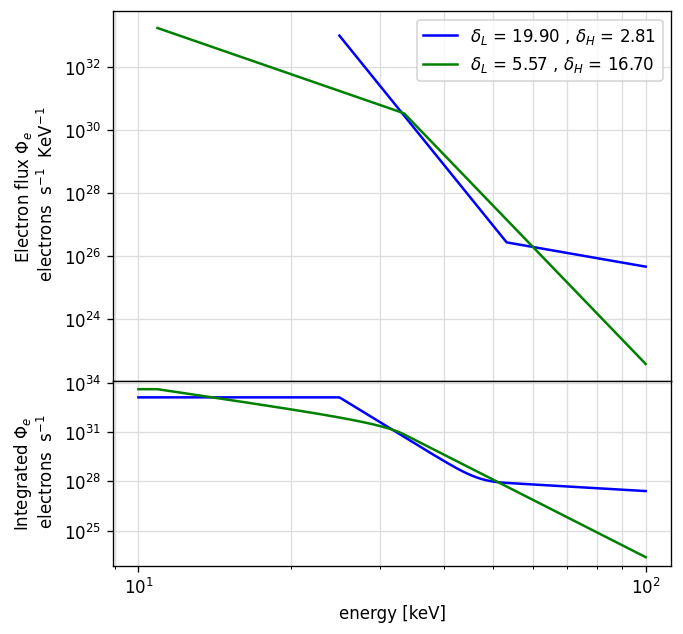

In [104]:
dp1 = double_powerlaw(19.9,24.9,0.010,2.81,53.2)
dp2 = double_powerlaw(5.57,10.9,0.0175,16.7,33.4)

pwl_ = [dp1,dp2]
plot_powerlaws(pwl_,e_range=[10,100],above=True,logx=True)

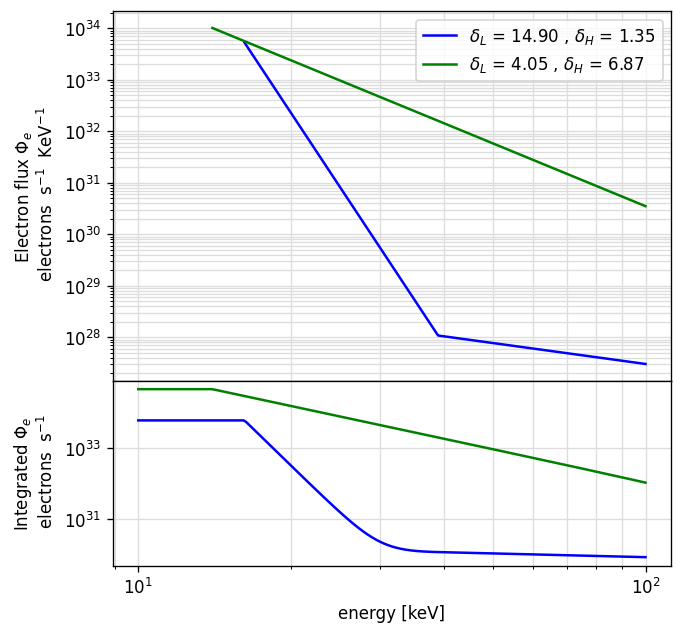

In [105]:
dp1 = double_powerlaw(14.9,16.2,0.0526,1.35,39)
dp2 = double_powerlaw(4.05,14,0.101,6.87,201)

pwl_ = [dp1,dp2]
plot_powerlaws(pwl_,e_range=[10,100],above=True,logx=True)

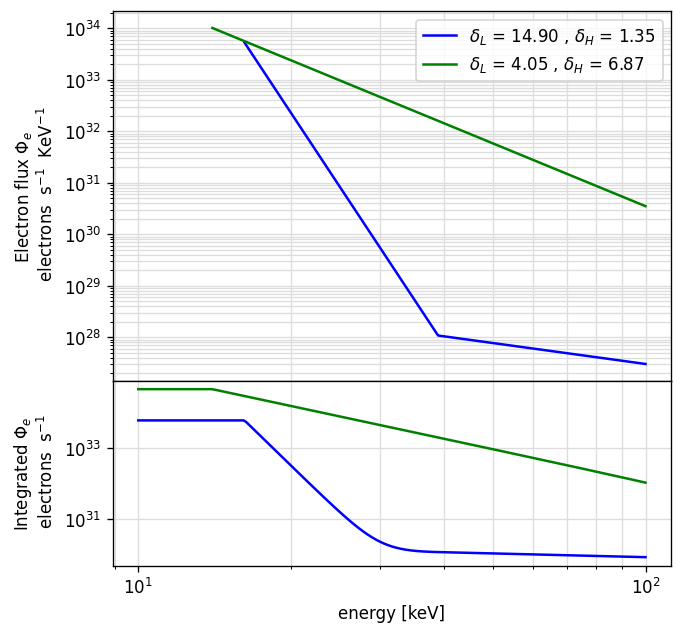

In [106]:
dp1 = double_powerlaw(14.9,16.2,0.0526,1.35,39)
dp2 = double_powerlaw(4.05,14,0.101,6.87,201)

pwl_ = [dp1,dp2]
plot_powerlaws(pwl_,e_range=[10,100],above=True,logx=True)

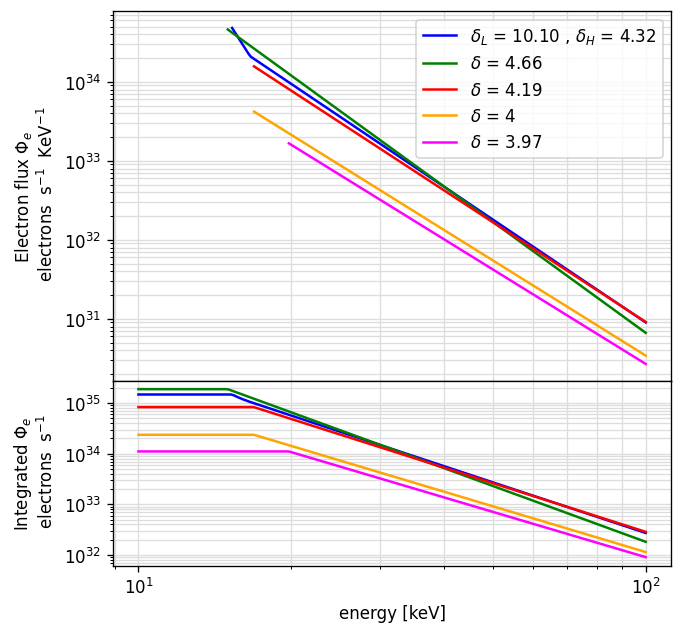

In [107]:
dp1 = double_powerlaw(10.1,15.3,0.481,4.32,16.6)
sp2 = powerlaw(4.66,15,0.46)
sp3  = powerlaw(4.19,16.9,flux_e_low_from_total_flux(4.19,0.832,16.9))
sp4  = powerlaw(4,16.9,0.042)
sp5  = powerlaw(3.97,19.8,flux_e_low_from_total_flux(3.97,0.111,19.8))

pwl_ = [dp1,sp2,sp3,sp4,sp5]
plot_powerlaws(pwl_,e_range=[10,100],above=True,logx=True)

In [101]:
x = powerlaw(4,10,0.01)

In [85]:
x.total_flux

0.03333333333333334

In [86]:
(x.delta-1)*(x.total_flux/x.e_low)

0.010000000000000002

In [87]:
(4.19-1)*(0.832/16.9)

0.15704615384615386

In [89]:
flux_e_low_from_total_flux(4.19,0.832,16.9)

0.15704615384615386

In [113]:
def keV_to_C(E):


    conv = 6.24e18 # ev per joule

    m = 9.31e-31 #kg
    c = 3e8 #m/S
    #v = 0.25
    
    eJ = E*1000/conv
    v_class = np.sqrt(2*eJ/m)/c
    
    return v_class
    
    
    

    return k_kev,k_kev_rel

def k_from_v(v):

    m = 9.31e-31 #kg
    c = 3e8 #m/S
    #v = 0.25

    beta = v
    gamma = 1/np.sqrt(1-beta**2)
    

    conv = 6.24e18 # ev perjoule
    k = 0.5*m*(v*c)**2 #kg m2/s2 Joule
    k_rel = (gamma-1)*m*c**2

    k_conv = conv*k #ev
    k_kev= k_conv/1000. #kev

    k_conv_rel = conv*k_rel #ev
    k_kev_rel= k_conv_rel/1000. #kev
    print('Vel {} c'.format(v))
    print("  Gamma = {}".format(gamma))
    print('  Classic {} keV'.format(k_kev))
    print('  Relativ {} keV'.format(k_kev_rel))
    
    return k_kev,k_kev_rel



In [114]:
keV_to_C()

0.2765932679989377

In [121]:
k_from_v(keV_to_C(2))

Vel 0.08746647123460059 c
  Gamma = 1.0038472808030932
  Classic 1.9999999999999998 keV
  Relativ 2.0115492289849355 keV


(1.9999999999999998, 2.0115492289849355)

In [127]:
k_from_v(0.12)

Vel 0.12 c
  Gamma = 1.0072787050317253
  Classic 3.7645171200000003 keV
  Relativ 3.805668014355582 keV


(3.7645171200000003, 3.805668014355582)